In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
meta = pd.read_csv("E:\Processed-LIDC-full-lung\Meta\meta_info.csv")
meta.head()

,patient_id,nodule_no,slice_no,original_image,mask_image,malignancy,is_cancer,is_clean,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,slice_thickness
0,1,0,0,0001_NI000_slice000,0001_MA000_slice000,5,True,False,5,1,6,4,4,3,5,5,2.5
1,1,0,1,0001_NI000_slice001,0001_MA000_slice001,5,True,False,5,1,6,4,4,3,5,5,2.5
2,1,0,2,0001_NI000_slice002,0001_MA000_slice002,5,True,False,5,1,6,4,4,3,5,5,2.5
3,1,0,3,0001_NI000_slice003,0001_MA000_slice003,5,True,False,5,1,6,4,4,3,5,5,2.5
4,1,0,4,0001_NI000_slice004,0001_MA000_slice004,5,True,False,5,1,6,4,4,3,5,5,2.5


In [3]:
DATA_PATH = "E:/Processed-LIDC-full-lung"

def get_orig_path(row):
    return "%s/Image/LIDC-IDRI-%04d/%s.npy" % (DATA_PATH, row.patient_id, row.original_image)

    
def get_mask_path(row):
    return "%s/Mask/LIDC-IDRI-%04d/%s.npy" % (DATA_PATH, row.patient_id, row.mask_image)


def mask_find_bboxs(mask):
    # 确保 mask 是单通道的
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # 将布尔类型转换为 uint8 类型
    if mask.dtype == bool:
        mask = mask.astype(np.uint8) * 255  # 转换为二值图像，True -> 255, False -> 0

    # 确保 mask 是二值图像
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    stats = stats[stats[:, 4].argsort()]
    return stats[:-1]  # 排除最外层的连通图

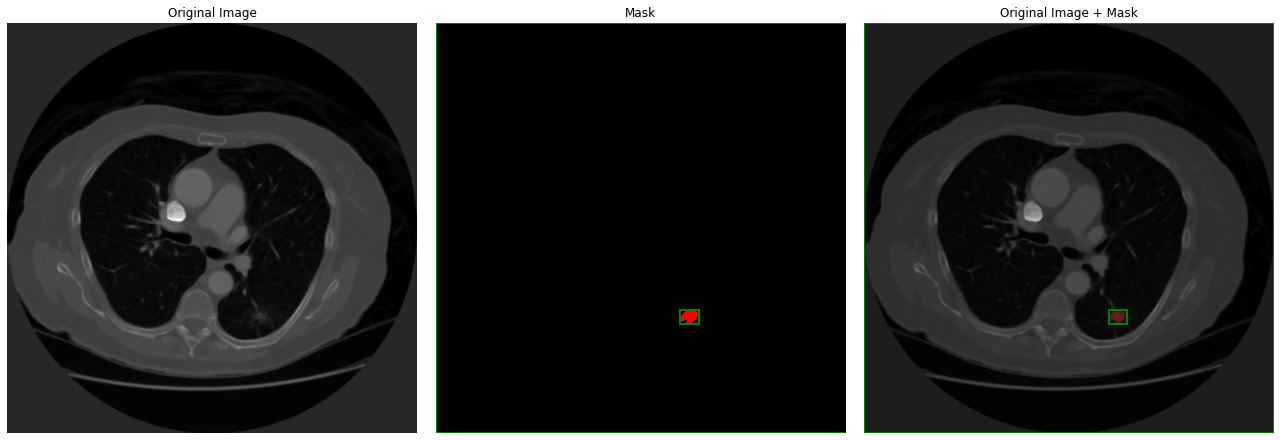

In [4]:
# 示例数据
row = meta.iloc[0]  # pd.Series
orig = np.load(get_orig_path(row))  # numpy.ndarray 512x512
mask = np.load(get_mask_path(row))  # numpy.ndarray 512x512

# 创建一个颜色映射，只在掩膜为1的区域显示颜色
colored_mask = np.zeros((*orig.shape, 3))  # 生成一个RGB图像
colored_mask[mask == 1] = [1, 0, 0]  # 将掩膜区域设置为红色

# 设置画布大小和子图
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1行3列

# 展示原始图像
axs[0].imshow(orig, cmap='gray')  # 使用灰度显示原始图像
axs[0].axis('off')  # 隐藏坐标轴
axs[0].set_title("Original Image")

# 展示掩膜
axs[1].imshow(colored_mask)  # 仅展示掩膜，标注区域为红色
axs[1].axis('off')  # 隐藏坐标轴
axs[1].set_title("Mask")

# 展示叠加的图像
# 注意这里要先绘制原图再叠加掩膜
axs[2].imshow(orig, cmap='gray')  # 原始图像
axs[2].imshow(colored_mask, alpha=0.25)  # 掩膜叠加
axs[2].axis('off')  # 隐藏坐标轴
axs[2].set_title("Original Image + Mask")

# 绘制边界框
bboxs = mask_find_bboxs(mask)
for bbox in bboxs:
    x, y, w, h, _ = bbox  # 解包边界框
    axs[1].add_patch(plt.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))  # 绘制绿色矩形
    axs[2].add_patch(plt.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))  # 绘制绿色矩形

plt.tight_layout()  # 调整布局
plt.show()